# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/14_resnet.ipynb)

In [1]:
import gc

from fastai.imports import *
from fastai.vision.all import *

import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
def get_dls(path, presize, resize):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, 
        item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=256, device=device)

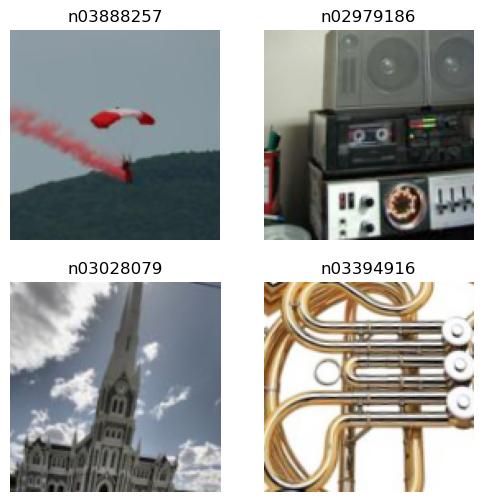

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

dls = get_dls(path, 160, 128)
dls.show_batch(max_n=4)

# Why Only Using Stride-2 Convs Is Bad

In [5]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

### The number of stride-2 convs assumes a certain input size to end with a grid size of 1

In [6]:
def stride2only_model():
    return sequential(
        conv(3, 4),
        conv(4, 8),
        conv(8, dls.c, act=False),
        Flatten(),
)

### It doesn't work with any input size

In [7]:
stride2only_model()(dls.one_batch()[0]).shape

torch.Size([256, 2560])

We got 160 activations?! We want to end up with 10 so that we can classify images into one of the 10 categories

In [8]:
def stride2only_model():
    return sequential(
        conv(3, 4),
        conv(4, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 128),
        conv(128, dls.c, act=False),
        Flatten(),
    )

stride2only_model()(dls.one_batch()[0]).shape

torch.Size([256, 10])

Ok, now it works, but we need to know in advance the input size so that we know how many conv2 we need to add to end up with the right number of activations, which makes our architecture not reusable!

You might say we can resize during inference, but think about it, imagine you are doing a vision model for car, does it make sense to crop the car on the left so that the image fits the size of your model? Not only it is unpratical but it is also dangerous.

# VGG 2013 Tried To Use Less Stride-2 Convs

### One Way We Could Avoid Infinite Sequences of Stride-2 Conv is Using A Dense Layer To Finish The Model

In [218]:
def vgg_model():
    return sequential(
       conv(3, 4),
        conv(4, 8),
        conv(8, 16),
        conv(16, 32),
        nn.Flatten(),  # Flatten the tensor
        nn.Linear(32 * 8 * 8, 128),  # First fully connected layer
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(64, dls.c)  # Output layer for 10 classes
    )

vgg_model()(dls.one_batch()[0]).shape

torch.Size([128, 10])

### But at what cost? The Weight Matrices Are Monstruous!

Compare the previous stride 2 only model

In [255]:
for l in stride2only_model():
    if isinstance(l, nn.Sequential):
        print(np.prod(l[0].weight.shape))

108
288
1152
4608
18432
73728
11520


In [256]:
np.prod(stride2only_model()[-3][0].weight.shape)

73728

To this vgg conv+dense layer model

In [259]:
for l in vgg_model():
    if isinstance(l, nn.Sequential):
        print(np.prod(l[0].weight.shape))
    if hasattr(l, 'weight'):
        print(np.prod(l.weight.shape))

108
288
1152
4608
262144
8192
640


In [258]:
np.prod(vgg_model()[5].weight.shape)

262144

That's monstruous!!! Imagine having a real image (not a little 128x128 pixel img). You will need to find a GPU that has enough ram to hold this!!!!

# FCN Is The Savior: Modern CNN Use Average Pooling

In [12]:
# ConvLayer is a thin wrapper around nn.Conv2d that includes batch norm and an activation function
def block(ni, nf): return ConvLayer(ni, nf, stride=2)

### Fully Convolutional Networks Can Deal With Any Image Size

With 1 Conv We End Up With 10 activations

In [277]:
def fcn_model():
    return nn.Sequential(
        block(3, 16),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(16, dls.c))

fcn_model()(dls.one_batch()[0]).shape

torch.Size([128, 10])

With More Conv We Still End Up With 10 activations!

In [278]:
def fcn_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

fcn_model()(dls.one_batch()[0]).shape

torch.Size([128, 10])

In [297]:
learn = Learner(dls, fcn_model(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
fcn_model()

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256

In [321]:
fcn_model()[-1]

Linear(in_features=256, out_features=10, bias=True)

We don't need to know hardcode the number of stride-2 convs and so the model can handle images of any size!

### How About The Weights?

Let's build a vgg model of the same size so that the comparison is fair

In [335]:
def vgg_model():
    return nn.Sequential(
        conv(3, 4),
        conv(4, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),  # Adding additional conv layers
        conv(64, 128), # Adding additional conv layers
        conv(128, 256),# Adding additional conv layers
        nn.Flatten(),  # Flatten the tensor
        nn.Linear(256 * 1 * 1, 50),  # Adjust input size to first fully connected layer
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),  # Optional dropout for regularization
        nn.Linear(50, 50),  # Second fully connected layer
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),  # Optional dropout for regularization
        nn.Linear(50, 10)  # Output layer for dls.c classes
    )

In [336]:
def calculate_weights_between_vgg_and_fcn():
    vgg = vgg_model()
    fcn = fcn_model()  

    # Function to extract weight shapes
    def extract_weight_shapes(model):
        shapes = []
        for l in model:
            if isinstance(l, nn.Sequential):
                shapes.append(np.prod(l[0].weight.shape))
            elif hasattr(l, 'weight'):
                shapes.append(np.prod(l.weight.shape))
        return shapes

    # Extract weight shapes for both models
    vgg_shapes = extract_weight_shapes(vgg)
    fcn_shapes = extract_weight_shapes(fcn)

    # Calculate total and peak weights
    total_vgg = sum([s for s in vgg_shapes if s is not None])
    peak_vgg = max([s for s in vgg_shapes if s is not None])
    total_fcn = sum([s for s in fcn_shapes if s is not None])
    peak_fcn = max([s for s in fcn_shapes if s is not None])

    # Create DataFrame with VGG and FCN columns
    max_length = max(len(vgg_shapes), len(fcn_shapes))
    vgg_shapes.extend([None] * (max_length - len(vgg_shapes)))
    fcn_shapes.extend([None] * (max_length - len(fcn_shapes)))

    df = pd.DataFrame({
        'VGG': vgg_shapes,
        'FCN': fcn_shapes
    })

    # Add total and peak weights as the last rows
    totals = pd.DataFrame([[total_vgg, total_fcn], [peak_vgg, peak_fcn]], columns=['VGG', 'FCN'])
    totals.index = ['Total Weights', 'Peak Weights']
    return pd.concat([df, totals])

calculate_weights_between_vgg_and_fcn()

,VGG,FCN
0,108,432.0
1,288,4608.0
2,1152,18432.0
3,4608,73728.0
4,18432,294912.0
5,73728,2560.0
6,294912,NaN
7,12800,NaN
8,2500,NaN
9,500,NaN


Almost the same, but...... let's see what happen with bigger image size

### The Ugly Secret of VGG: Weights Grow Exponentially With Image Sizes

The vgg was doing ok previously because it had enough stride-2 conv to reduce the grid size to 1, but what if the final conv doesn't end with a grid size of 1? What if it ends with a grid of 4?

In [348]:
def vgg_model():
    return nn.Sequential(
        conv(3, 4),
        conv(4, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 128),
        conv(128, 256),
        nn.Flatten(),
        # assuming the input is now 512x512
        # 4 because we do 512/2^7 (7 convs)
        nn.Linear(256 * 4 * 4, 50),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(50, 50),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(50, 10)
    )

In [349]:
calculate_weights_between_vgg_and_fcn()

,VGG,FCN
0,108,432.0
1,288,4608.0
2,1152,18432.0
3,4608,73728.0
4,18432,294912.0
5,73728,2560.0
6,294912,NaN
7,204800,NaN
8,2500,NaN
9,500,NaN


You can see that VGG just doesn't scale, the number of weights keeps growing depending on the image size. While for the FCN, it just stopped at the average pooling layer.

Also we just use a hidden of 50! Imagine if we had a hidden of 512! It would be a lot more weights!
Another to take in consideration are the multiplications they are much larger with the dense layer!


# FCN Can't Go Very Deep

To understand why, look at the `why_resnet.ipnyb` notebook

# The Effect Of Average Pooling

Lastly, let's take a look at the effect of having and not having average pooling for a given model

In [11]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#3) [Path('.DS_Store'),Path('training'),Path('testing')]

In [12]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

In [14]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

### First Without Average Pooling

In [17]:
def no_avg_pool_model():
    return sequential(
        conv(1 ,8, ks=5),        #next inputs = 14x14
        conv(8 ,16),             #next inputs = 7x7
        conv(16,32),             #next inputs = 4x4
        conv(32,64),             #next inputs = 2x2
        conv(64,10, act=False),  #next inputs = 1x1
        Flatten(),
    )

In [18]:
learn = Learner(dls, no_avg_pool_model(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit_one_cycle(3, 3e-3)

/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.125054,0.077854,0.983100,01:00
1,0.061083,0.044662,0.988700,00:58
2,0.034532,0.030342,0.991500,00:56


### Then Average Pooling

In [19]:
def average_pool_model():
    return sequential(
        conv(1 ,8, ks=5),        #next inputs = 14x14
        conv(8 ,16),             #next inputs = 7x7
        conv(16,32),             #next inputs = 4x4
        conv(32,64),             #next inputs = 2x2
        conv(64,10, act=False),  #next inputs = 1x1
        Flatten(),
    )

learn = Learner(dls, average_pool_model(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit_one_cycle(3, 3e-3)

/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.138371,0.114274,0.975800,00:56
1,0.061704,0.045370,0.987900,00:53
2,0.036462,0.031292,0.991100,00:53
